#### Примечание

Этот проект основан на найденном мной датасете на Kaggle, который показался мне интересным.
Ссылка - https://www.kaggle.com/manishkc06/startup-success-prediction.

#### Описание
"Стартап — это компания или проект, созданный предпринимателем для поиска, разработки и проверки масштабируемой экономической модели. В то время как предпринимательство относится ко всем новым предприятиям, включая самозанятость и предприятия, которые никогда не собираются регистрироваться, стартапы относятся к новым предприятиям, которые намереваются вырасти до масштабов серьезного бизнеса. Стартапы сталкиваются с высокой степенью неопределенности и имеют высокий уровень неудач, но меньшинство из них становится успешными и влиятельными. Некоторые стартапы становятся единорогами: частные стартапы оцениваются более чем в 1 миллиард долларов США." 
Источник - Википедия.

Стартапы играют важную роль в экономическом росте. Они приносят новые идеи, стимулируют инновации, создают рабочие места, тем самым двигая экономику. За последние несколько лет наблюдается экспоненциальный рост стартапов. Прогнозирование успеха стартапа позволяет инвесторам находить компании с потенциалом быстрого роста, тем самым позволяя им быть на шаг впереди конкурентов.

#### Цель
Цель состоит в том, чтобы предсказать, станет ли стартап, который работает в настоящее время, успешным или неудачным. Успех компании определяется как событие, которое дает учредителям компании крупную сумму денег в процессе M&A (слияния и поглощения) или IPO (первичное публичное размещение акций). Компания будет считаться несостоятельной, если ее придется закрыть.

#### Данные
Данные содержат отраслевые тенденции, информацию об инвестициях и информацию об отдельных компаниях США. Изначально в датасете 48 столбцов. Ниже приведено описание большинства из них, однако некоторые не удалось корректно интерпретировать, поэтому они были удалены.

 - state_code – categorical 
 - agefirstfunding_year – quantitative 
 - agelastfunding_year – quantitative
 - relationships – quantitative
 - funding_rounds – quantitative
 - fundingtotalusd – quantitative
 - milestones – quantitative
 - agefirstmilestone_year – quantitative
 - agelastmilestone_year – quantitative
 - state – categorical
 - industry_type – categorical
 - has_VC – categorical
 - has_angel – categorical
 - has_roundA – categorical
 - has_roundB – categorical
 - has_roundC – categorical
 - has_roundD – categorical
 - avg_participants – quantitative
 - is_top500 – categorical
 - status(acquired/closed) – categorical (the target variable, if a startup is ‘acquired’ by some other organization, means the startup succeed) 
 
#### Plan
1. Подготовка - 11.01.2022 - Done
2. EDA - 19.01.2022
3. Обучение - 23.01.2022
4. Тестирование и визуализация - 31.01.2022

### Импорт библиотек

In [79]:
# Импорт библиотек для анализа
import pandas as pd
import numpy as np
import missingno as msgn
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind
import association_metrics as am
import plotly.express as px

# Импорт библиотек для ML
from sklearn.model_selection import train_test_split,GridSearchCV 
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier

# Импорт библиотек для оценки качества модели
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

In [80]:
# Импорт данных
df = pd.read_csv('startup data.csv')

In [81]:
# Параметры отображения данных
pd.set_option('display.max_columns', None)

### Подготовка функций

In [82]:
# функция для поиска выбросов методом IQR
def find_outliers(data):
    for col in data.columns:
        if data[col].dtype != 'O':
            counter = 0
            Q1 = data[col].quantile(0.25)
            Q3 = data[col].quantile(0.75)
            IQR = Q3 - Q1
            for string in df[col]:
                if (string < (Q1 - 1.5 * IQR) or string > (Q3 + 1.5 * IQR)):
                    counter += 1
            print('количество выбросов в столбце {}'.format(col), '-', counter)
            
# функция для отрисовки корелляции Пирсона
def pearson_correlation(dataset):
    matrix = dataset.corr(method='pearson')
    display(sns.heatmap(matrix, annot=True))
    
def spearman_correlation(dataset):
    matrix = dataset.corr(method='spearman')
    display(sns.heatmap(matrix, annot=True))

def Kendall_correlation(dataset):
    matrix = dataset.corr(method='kendall')
    display(sns.heatmap(matrix, annot=True))
    
# функция для теста Стьюдента
def student_test(data,column):
    cols = data.loc[:, column].value_counts().index
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(data.loc[data.loc[:, column] == comb[0], 'labels'], data.loc[data.loc[:, column] == comb[1], 'labels']).pvalue <= 0.05/len(combinations_all):  # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break

# Функция для отрисовки ROC кривой
def calc_and_plot_roc(y_true, y_valid):
    # Посчитать значения ROC кривой и значение площади под кривой AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.title('Receiver Operating Characteristic', fontsize=15)
    plt.xlabel('False positive rate (FPR)', fontsize=15)
    plt.ylabel('True positive rate (TPR)', fontsize=15)
    plt.legend(fontsize=15)

### EDA

#### Оценка данных

Первым делом посмотрим на сами данные. Для общего понимания интересуют первые несколько строк и описание типов данных.

In [83]:
display(df)
df.info()

,Unnamed: 0,state_code,latitude,longitude,zip_code,id,city,Unnamed: 6,name,labels,founded_at,closed_at,first_funding_at,last_funding_at,age_first_funding_year,age_last_funding_year,age_first_milestone_year,age_last_milestone_year,relationships,funding_rounds,funding_total_usd,milestones,state_code.1,is_CA,is_NY,is_MA,is_TX,is_otherstate,category_code,is_software,is_web,is_mobile,is_enterprise,is_advertising,is_gamesvideo,is_ecommerce,is_biotech,is_consulting,is_othercategory,object_id,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,is_top500,status
0,1005,CA,42.358880,-71.056820,92101,c:6669,San Diego,NaN,Bandsintown,1,1/1/2007,NaN,4/1/2009,1/1/2010,2.2493,3.0027,4.6685,6.7041,3,3,375000,3,CA,1,0,0,0,0,music,0,0,0,0,0,0,0,0,0,1,c:6669,0,1,0,0,0,0,1.0000,0,acquired
1,204,CA,37.238916,-121.973718,95032,c:16283,Los Gatos,NaN,TriCipher,1,1/1/2000,NaN,2/14/2005,12/28/2009,5.1260,9.9973,7.0055,7.0055,9,4,40100000,1,CA,1,0,0,0,0,enterprise,0,0,0,1,0,0,0,0,0,0,c:16283,1,0,0,1,1,1,4.7500,1,acquired
2,1001,CA,32.901049,-117.192656,92121,c:65620,San Diego,San Diego CA 92121,Plixi,1,3/18/2009,NaN,3/30/2010,3/30/2010,1.0329,1.0329,1.4575,2.2055,5,1,2600000,2,CA,1,0,0,0,0,web,0,1,0,0,0,0,0,0,0,0,c:65620,0,0,1,0,0,0,4.0000,1,acquired
3,738,CA,37.320309,-122.050040,95014,c:42668,Cupertino,Cupertino CA 95014,Solidcore Systems,1,1/1/2002,NaN,2/17/2005,4/25/2007,3.1315,5.3151,6.0027,6.0027,5,3,40000000,1,CA,1,0,0,0,0,software,1,0,0,0,0,0,0,0,0,0,c:42668,0,0,0,1,1,1,3.3333,1,acquired
4,1002,CA,37.779281,-122.419236,94105,c:65806,San Francisco,San Francisco CA 94105,Inhale Digital,0,8/1/2010,10/1/2012,8/1/2010,4/1/2012,0.0000,1.6685,0.0384,0.0384,2,2,1300000,1,CA,1,0,0,0,0,games_video,0,0,0,0,0,1,0,0,0,0,c:65806,1,1,0,0,0,0,1.0000,1,closed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
918,352,CA,37.740594,-122.376471,94107,c:21343,San Francisco,NaN,CoTweet,1,1/1/2009,NaN,7/9/2009,7/9/2009,0.5178,0.5178,0.5808,4.5260,9,1,1100000,2,CA,1,0,0,0,0,advertising,0,0,0,0,1,0,0,0,0,0,c:21343,0,0,1,0,0,0,6.0000,1,acquired
919,721,MA,42.504817,-71.195611,1803,c:41747,Burlington,Burlington MA 1803,Reef Point Systems,0,1/1/1998,6/25/2008,4/1/2005,3/23/2007,7.2521,9.2274,6.0027,6.0027,1,3,52000000,1,MA,0,0,1,0,0,security,0,0,0,0,0,0,0,0,0,1,c:41747,1,0,0,1,0,0,2.6667,1,closed
920,557,CA,37.408261,-122.015920,94089,c:31549,Sunnyvale,NaN,Paracor Medical,0,1/1/1999,6/17/2012,6/29/2007,6/29/2007,8.4959,8.4959,9.0055,9.0055,5,1,44000000,1,CA,1,0,0,0,0,biotech,0,0,0,0,0,0,0,1,0,0,c:31549,0,0,0,0,0,1,8.0000,1,closed
921,589,CA,37.556732,-122.288378,94404,c:33198,San Francisco,NaN,Causata,1,1/1/2009,NaN,10/5/2009,11/1/2011,0.7589,2.8329,0.7589,3.8356,12,2,15500000,2,CA,1,0,0,0,0,software,1,0,0,0,0,0,0,0,0,0,c:33198,0,0,1,1,0,0,1.0000,1,acquired


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 923 entries, 0 to 922
Data columns (total 49 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                923 non-null    int64  
 1   state_code                923 non-null    object 
 2   latitude                  923 non-null    float64
 3   longitude                 923 non-null    float64
 4   zip_code                  923 non-null    object 
 5   id                        923 non-null    object 
 6   city                      923 non-null    object 
 7   Unnamed: 6                430 non-null    object 
 8   name                      923 non-null    object 
 9   labels                    923 non-null    int64  
 10  founded_at                923 non-null    object 
 11  closed_at                 335 non-null    object 
 12  first_funding_at          923 non-null    object 
 13  last_funding_at           923 non-null    object 
 14  age_first_

Итого есть 14 тектосвых признаков (object) и 35 числовых признаков (int64,float64). Это хорошо, т.к числовые нам как раз и нужны для обучения модели.
Далее нужно оценить данные на наличие пропусков и дубликатов. Для пропусков нужно подобрать оптимальные варианты заполнения. 

Unnamed: 0                    0
state_code                    0
latitude                      0
longitude                     0
zip_code                      0
id                            0
city                          0
Unnamed: 6                  493
name                          0
labels                        0
founded_at                    0
closed_at                   588
first_funding_at              0
last_funding_at               0
age_first_funding_year        0
age_last_funding_year         0
age_first_milestone_year    152
age_last_milestone_year     152
relationships                 0
funding_rounds                0
funding_total_usd             0
milestones                    0
state_code.1                  1
is_CA                         0
is_NY                         0
is_MA                         0
is_TX                         0
is_otherstate                 0
category_code                 0
is_software                   0
is_web                        0
is_mobil

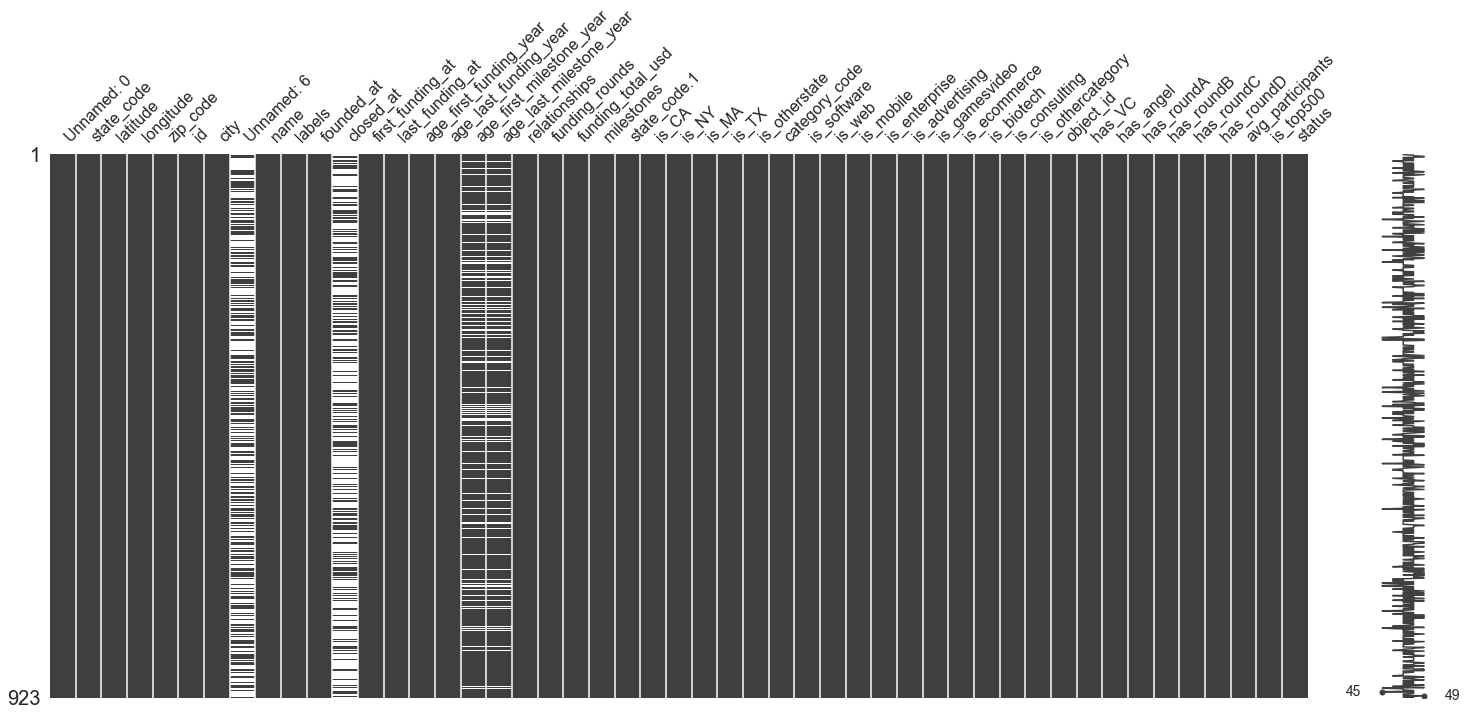

In [84]:
#Выводим анализ пропусков в числовом формате, а также в формате графической матрицы

display(df.isnull().sum())
msgn.matrix(df)

In [85]:
# Проверяем данные на наличие дубликатов

df.duplicated().sum()

0

Итак, первые выводы - количество столбцов велико, но пропуски есть только в четырех. Дубликатов не обнаружено. Это весьма неплохо, рутинной работы будет меньше. 

In [86]:
df

,Unnamed: 0,state_code,latitude,longitude,zip_code,id,city,Unnamed: 6,name,labels,founded_at,closed_at,first_funding_at,last_funding_at,age_first_funding_year,age_last_funding_year,age_first_milestone_year,age_last_milestone_year,relationships,funding_rounds,funding_total_usd,milestones,state_code.1,is_CA,is_NY,is_MA,is_TX,is_otherstate,category_code,is_software,is_web,is_mobile,is_enterprise,is_advertising,is_gamesvideo,is_ecommerce,is_biotech,is_consulting,is_othercategory,object_id,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,is_top500,status
0,1005,CA,42.358880,-71.056820,92101,c:6669,San Diego,NaN,Bandsintown,1,1/1/2007,NaN,4/1/2009,1/1/2010,2.2493,3.0027,4.6685,6.7041,3,3,375000,3,CA,1,0,0,0,0,music,0,0,0,0,0,0,0,0,0,1,c:6669,0,1,0,0,0,0,1.0000,0,acquired
1,204,CA,37.238916,-121.973718,95032,c:16283,Los Gatos,NaN,TriCipher,1,1/1/2000,NaN,2/14/2005,12/28/2009,5.1260,9.9973,7.0055,7.0055,9,4,40100000,1,CA,1,0,0,0,0,enterprise,0,0,0,1,0,0,0,0,0,0,c:16283,1,0,0,1,1,1,4.7500,1,acquired
2,1001,CA,32.901049,-117.192656,92121,c:65620,San Diego,San Diego CA 92121,Plixi,1,3/18/2009,NaN,3/30/2010,3/30/2010,1.0329,1.0329,1.4575,2.2055,5,1,2600000,2,CA,1,0,0,0,0,web,0,1,0,0,0,0,0,0,0,0,c:65620,0,0,1,0,0,0,4.0000,1,acquired
3,738,CA,37.320309,-122.050040,95014,c:42668,Cupertino,Cupertino CA 95014,Solidcore Systems,1,1/1/2002,NaN,2/17/2005,4/25/2007,3.1315,5.3151,6.0027,6.0027,5,3,40000000,1,CA,1,0,0,0,0,software,1,0,0,0,0,0,0,0,0,0,c:42668,0,0,0,1,1,1,3.3333,1,acquired
4,1002,CA,37.779281,-122.419236,94105,c:65806,San Francisco,San Francisco CA 94105,Inhale Digital,0,8/1/2010,10/1/2012,8/1/2010,4/1/2012,0.0000,1.6685,0.0384,0.0384,2,2,1300000,1,CA,1,0,0,0,0,games_video,0,0,0,0,0,1,0,0,0,0,c:65806,1,1,0,0,0,0,1.0000,1,closed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
918,352,CA,37.740594,-122.376471,94107,c:21343,San Francisco,NaN,CoTweet,1,1/1/2009,NaN,7/9/2009,7/9/2009,0.5178,0.5178,0.5808,4.5260,9,1,1100000,2,CA,1,0,0,0,0,advertising,0,0,0,0,1,0,0,0,0,0,c:21343,0,0,1,0,0,0,6.0000,1,acquired
919,721,MA,42.504817,-71.195611,1803,c:41747,Burlington,Burlington MA 1803,Reef Point Systems,0,1/1/1998,6/25/2008,4/1/2005,3/23/2007,7.2521,9.2274,6.0027,6.0027,1,3,52000000,1,MA,0,0,1,0,0,security,0,0,0,0,0,0,0,0,0,1,c:41747,1,0,0,1,0,0,2.6667,1,closed
920,557,CA,37.408261,-122.015920,94089,c:31549,Sunnyvale,NaN,Paracor Medical,0,1/1/1999,6/17/2012,6/29/2007,6/29/2007,8.4959,8.4959,9.0055,9.0055,5,1,44000000,1,CA,1,0,0,0,0,biotech,0,0,0,0,0,0,0,1,0,0,c:31549,0,0,0,0,0,1,8.0000,1,closed
921,589,CA,37.556732,-122.288378,94404,c:33198,San Francisco,NaN,Causata,1,1/1/2009,NaN,10/5/2009,11/1/2011,0.7589,2.8329,0.7589,3.8356,12,2,15500000,2,CA,1,0,0,0,0,software,1,0,0,0,0,0,0,0,0,0,c:33198,0,0,1,1,0,0,1.0000,1,acquired


#### Обзор столбцов

##### Unnamed: 0
Что означает этот столбец - расшифровать, к сожалению, не удалось. Поэтому просто удалим его.

In [87]:
df.drop('Unnamed: 0',axis=1,inplace=True)

##### state_code
Этот столбец содержит коды штатов США, в которых зарегистрированы стратапы. Его можно рассмотреть подробнее и сделать OneHot encoding.

CA    488
NY    106
MA     83
TX     42
WA     42
CO     19
IL     18
PA     17
VA     13
GA     11
NC      7
OR      7
NJ      7
MD      7
FL      6
OH      6
MN      5
DC      4
CT      4
TN      3
RI      3
UT      3
MI      3
MO      2
NH      2
KY      2
ME      2
NV      2
IN      2
AZ      2
WV      1
NM      1
ID      1
AR      1
WI      1
Name: state_code, dtype: int64

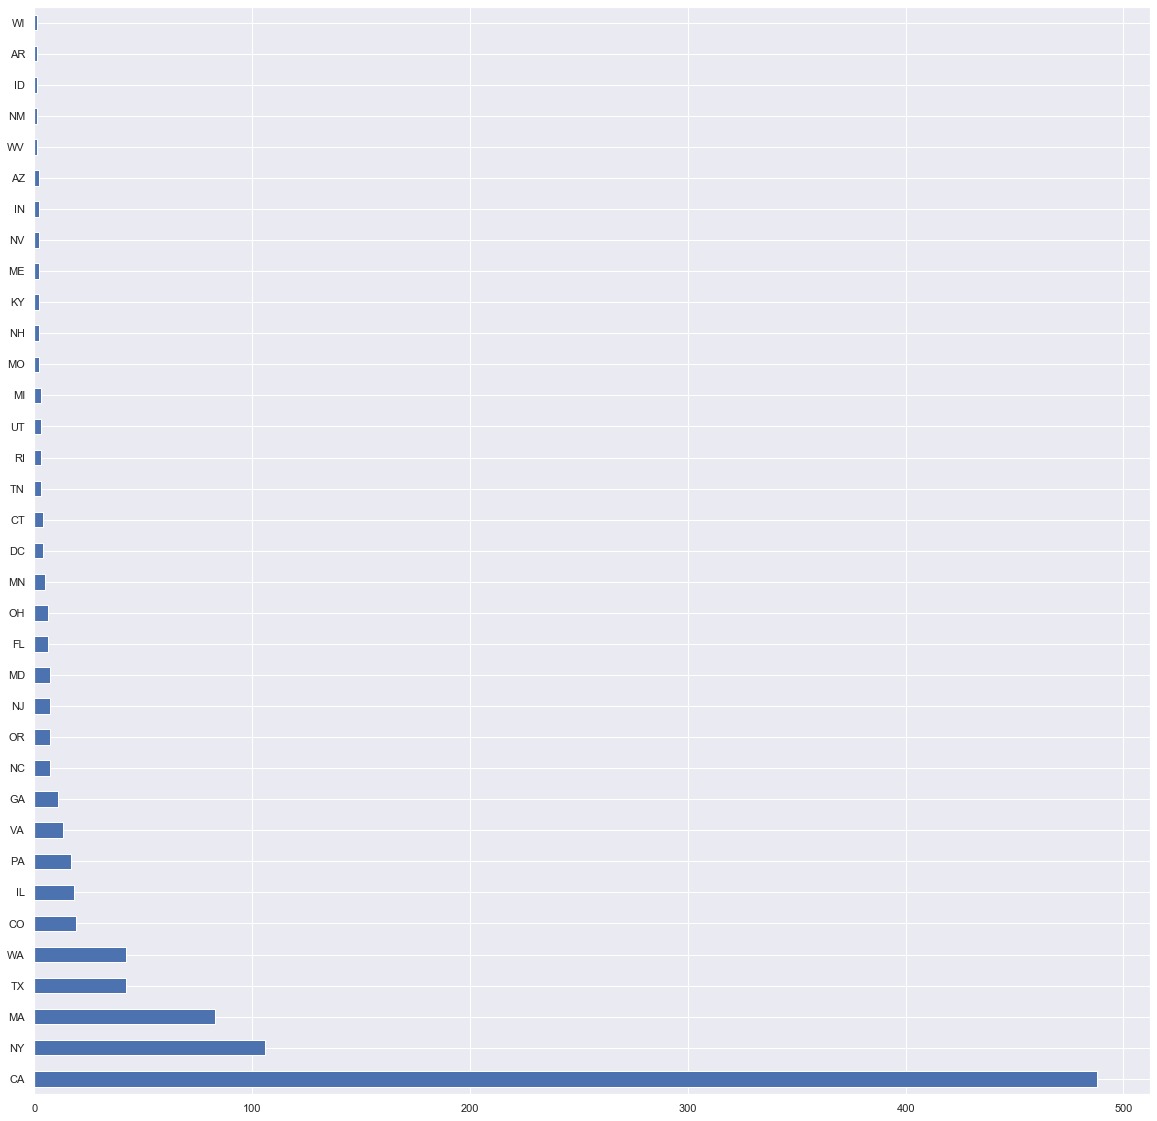

In [88]:
display(df.state_code.value_counts())
plt.rcParams["figure.figsize"] = (20,20)
df.state_code.value_counts().plot.barh()

Как видим, больше половины всех стартапов в датасете родом и солнечной Калифорнии. Не удивительно, Кремниевая Долина!
Энкодинг этого столбца уже сделан, но наполовину. Удалим текущие признаки и потом сделаем заново.

In [89]:
df = df.drop(['is_CA',
'is_NY', \
'is_MA', \
'is_TX', \
'is_otherstate'],axis=1)

##### latitude и longtitude
Это геоданные, которые соответствуют адресу компании. Я проверил эти данные - некоторые из них привязаны к офисным зданиям, но многие ведут на известные места типа San Francisco City Hall или вообще жилые дома. Тем не менее, очень интересно будет построить из них карту.
Для этого подойдет инструмент scatter_mapbox из пакета plotly.express

In [126]:
px.set_mapbox_access_token(open(".mapbox_token").read())
fig = px.scatter_mapbox(df, lat="latitude", 
                        lon="longitude", 
                        color='category_code',
                        hover_name="name",
                        zoom = 3)
fig.show()

Из этой карты можно сделать сразу несколько выводов:
 - Для стартапов категории network_hosting наименее принципиально расположение в крупных городах, даже наборот - они стараются выбирать центральные штаты, видимо из-за цен на электроэнергию и аренду мощностей. Исключение - агломерация Сан-Франциско.
 - Стартапы категории hardware расположены в тех штатах, где есть либо граница с Канадой или Мексикой, либо близость к крупным портам, что может говорить об ориентированности на экспорт.

In [124]:
df[df['category_code']=='public_relations']['name']

15                     Invicta Networks
24                             EventVue
26                      Scalent Systems
31                    Lockdown Networks
53                    Colubris Networks
95                  Blue Vector Systems
207                         OfferLounge
262                           PacketHop
284                             Q-magic
298                     Cerona Networks
403           Cloverleaf Communications
476                          AppTrigger
511                              Atrica
576                          T-Networks
582                            Neterion
604                     Navini Networks
621                           Coradiant
625              TelASIC Communications
645              Blue Lane Technologies
679                           NewsBasis
772                              Vontoo
839                            DotSpots
859    LifeSize, a Division of Logitech
868                      Digit Wireless
905                   Broadway Networks


##### zip_code
Ничего необычного, просто почтовый индекс. Оставляем.

##### id
Это уникальный id, который присвоен каждому стартапу. У каждого id в самом начале есть некрасивая приписка c: (видимо, client). Уберем её.

In [12]:
# Делаем замену
df.id = df.id.apply( lambda x: int((str(x).replace('c:',''))))

In [13]:
# проверим, все ли значения уникальны
df.id.value_counts()

28482    2
6669     1
1445     1
55421    1
28403    1
        ..
30       1
282      1
6340     1
9599     1
26702    1
Name: id, Length: 922, dtype: int64

In [14]:
# есть дубликат. Посмотрим на него
df[df.id==28482]

,state_code,latitude,longitude,zip_code,id,city,Unnamed: 6,name,labels,founded_at,closed_at,first_funding_at,last_funding_at,age_first_funding_year,age_last_funding_year,age_first_milestone_year,age_last_milestone_year,relationships,funding_rounds,funding_total_usd,milestones,state_code.1,category_code,is_software,is_web,is_mobile,is_enterprise,is_advertising,is_gamesvideo,is_ecommerce,is_biotech,is_consulting,is_othercategory,object_id,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,is_top500,status
124,CA,37.54827,-121.988572,94538,28482,Fremont,Fremont CA 94538,Redwood Systems,1,1/1/2008,NaN,10/3/2008,5/30/2012,0.7562,4.4137,2.7836,4.0027,14,4,34250000,2,CA,cleantech,0,0,0,0,0,0,0,0,0,1,c:28482,1,0,1,1,1,0,2.25,1,acquired
832,CA,37.48151,-121.945328,94538,28482,Fremont,NaN,Redwood Systems,1,1/1/2008,NaN,10/3/2008,5/30/2012,0.7562,4.4137,2.7836,4.0027,14,4,34250000,2,CA,cleantech,0,0,0,0,0,0,0,0,0,1,c:28482,1,0,1,1,1,0,2.25,1,acquired


Все-таки у нас нашелся один дубликат - компания из города Fremont,СA, которая указана два раза. Это кстати, косвенно подтверждает бесполезность широты и долготы. 

In [15]:
# Удалим последнюю
df.drop(df.index[[832]],inplace=True)

##### city
Как не сложно догадаться из названия столбца, это город, в котором зарегистрирована компания.
распределение по этому столбцу будет примерно соответствовать распределению по штатам. Оставляем как есть.

##### Unnamed: 6	

Этот столбец без имени содержит город, штат и почтовый индекс, соответствующий адресу регистрации компании. Колонка имеет много пропусков, временные затраты на добычу этих данных не выглядят оправданными. Поэтому удаляем ее

In [16]:
df.drop('Unnamed: 6',axis=1,inplace=True)

##### name	

Один из важнейших столбцов - имя компании. Название бренда может сыграть весьма значительную роль в развитии компании и доверии к ней инвесторов и потенциальных клиентов. Оставляем как есть.

##### age_first_milestone_year и age_last_milestone_year

Эти признаки содержат годы первого и последнего milestone. Milestone - это важная контрольная точка в развитии стартапа, при прохождении которой можно оценить, насколько компания следует дорожной карте. Эти данные могли бы быть весьма полезны при обучении модели, однако в них слишком много пропусков, и заполнить их проблематично. Поэтому придется удалить.

In [17]:
df.drop(['age_first_milestone_year','age_last_milestone_year'],axis=1,inplace=True)

##### labels и status

Целевой столбец, по которому мы будем обучать модель - labels. Он представляет собой бинарную версию столбца status. 1 означает, что стартап получил деньги, 0 - что он провалился. Посмотрим на распределение и посчитаем процент успешных компаний.

Количество успешных стартапов: 596
Количество провалившихся стартапов: 326
Доля успешных стартапов: 54 %
Доля провалившихся стартапов: 46 %


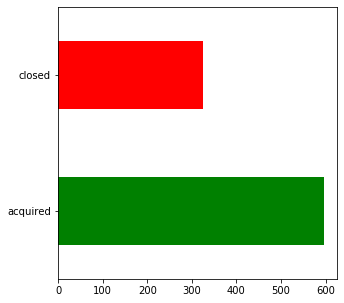

In [18]:
aquired = df[df.labels==1]['labels'].count()
closed = df[df.labels==0]['labels'].count()
aquired_perc = closed/aquired*100
closed_perc = 100-int(aquired_perc)  #без добавления int округление работало в сторону уменьшения

print('Количество успешных стартапов:',aquired)
print('Количество провалившихся стартапов:',closed)
print('Доля успешных стартапов:',int(aquired_perc),'%')
print('Доля провалившихся стартапов:',int(closed_perc),'%')
plt.rcParams["figure.figsize"] = (5,5)
df.status.value_counts().plot.barh(color={"green": "acquired", "red": "closed"})

Большинство стартапов все же получило финансирование. Жаль нет аналогичной статистики по России.

##### founded_at, first_funding_at, last_funding_at

Эти признаки позволяют описывают дату основания и также даты первого и последнего финансирования.
Есть еще один признак - closed at, означающий дату закрытия стартапа, но он равен целевой переменной (поскольку закрытие - это значение, а успех - пропуск. closed at удалим, остальные признаки пока не будем трогать.

In [19]:
df.drop('closed_at',axis=1,inplace=True)

##### category_code

Этот признак означает сферу, в направлении которой работает комания. Интересно посмотреть на распределение по сферам.

software            153
web                 144
mobile               79
enterprise           73
advertising          62
games_video          52
semiconductor        35
network_hosting      34
biotech              34
hardware             27
ecommerce            25
public_relations     25
cleantech            22
security             19
analytics            19
social               14
search               12
other                11
messaging            11
fashion               8
travel                8
news                  8
medical               7
photo_video           7
music                 6
finance               6
education             4
consulting            3
real_estate           3
health                3
automotive            2
manufacturing         2
transportation        2
hospitality           1
sports                1
Name: category_code, dtype: int64

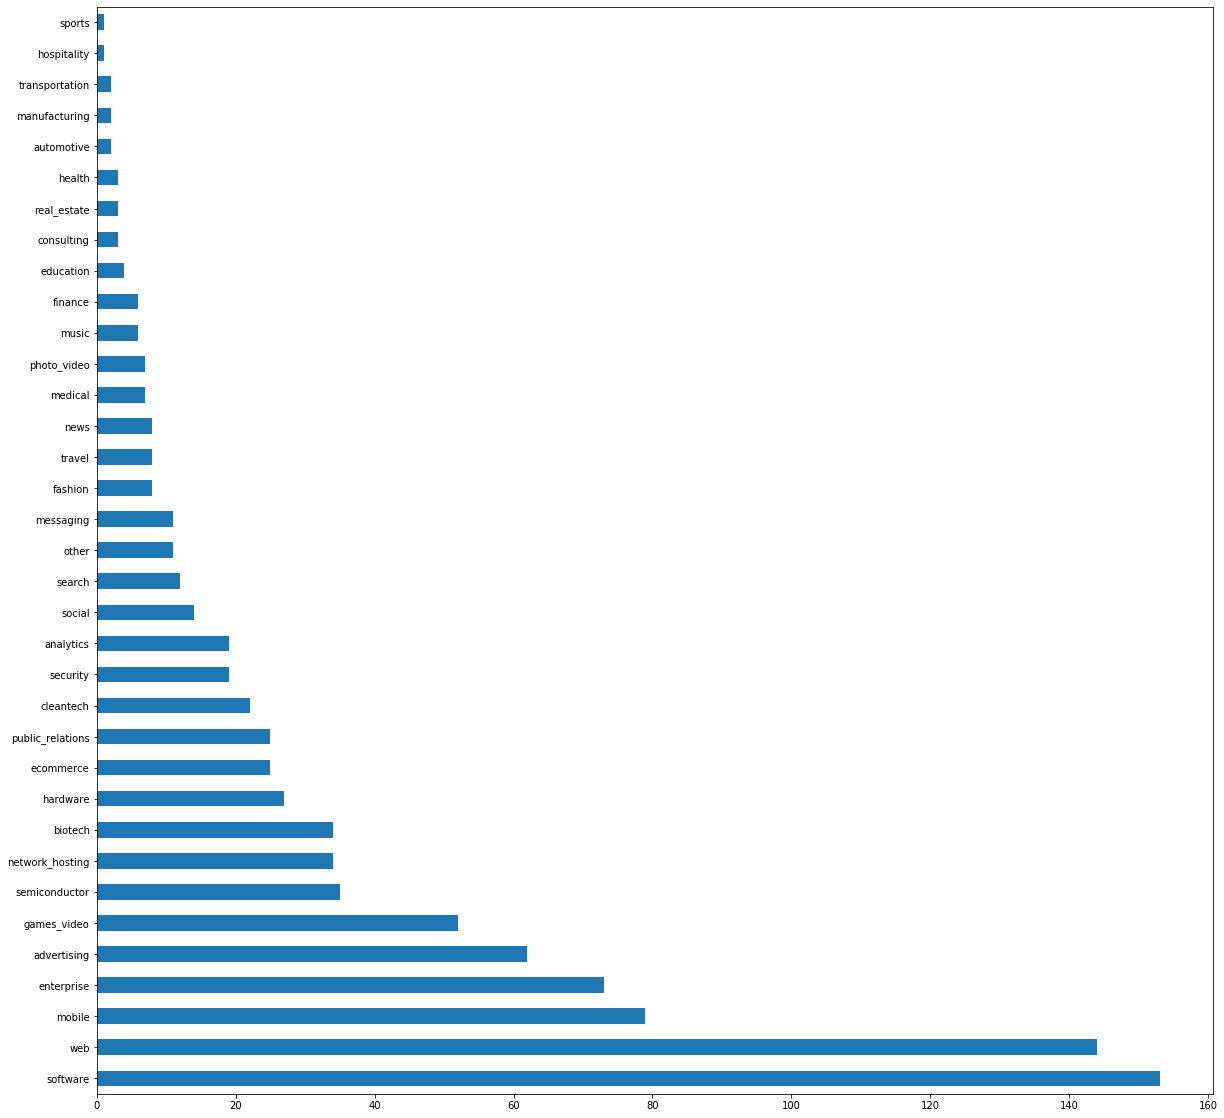

In [20]:
display(df.category_code.value_counts())
plt.rcParams["figure.figsize"] = (20,20)
df.category_code.value_counts().plot.barh()

Лидирует категория software, однако я думаю, что сюда относится все то, что не удалось классифицировать более тщательно. Например, web и mobile в данном случае - просто более узкие категории software. Тем не менее, этот признак может сыграть свою роль в построении модели.
В датасете есть бинарные признаки с категориями вида 'is software','is web' и т.д. Категорий явно больше, поэтому удалим их и чутьпозже сделаем OneHotEncoding признака category_code, чтобы получить полный перечень категорий без дубляжей.

In [21]:
df = df.drop(['is_software',
'is_web', \
'is_mobile', \
'is_enterprise', \
'is_advertising', \
'is_ecommerce', \
'is_gamesvideo', \
'is_biotech', \
'is_consulting', \
'is_othercategory'],axis=1)

Все остальные признаки числовые, либо бинарные. Подробнее рассматривать их не будем. Разве что удалим два дублирующих столбца.

In [22]:
df.drop(['object_id','state_code.1'],axis=1,inplace=True)

In [23]:
df

,state_code,latitude,longitude,zip_code,id,city,name,labels,founded_at,first_funding_at,last_funding_at,age_first_funding_year,age_last_funding_year,relationships,funding_rounds,funding_total_usd,milestones,category_code,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,is_top500,status
0,CA,42.358880,-71.056820,92101,6669,San Diego,Bandsintown,1,1/1/2007,4/1/2009,1/1/2010,2.2493,3.0027,3,3,375000,3,music,0,1,0,0,0,0,1.0000,0,acquired
1,CA,37.238916,-121.973718,95032,16283,Los Gatos,TriCipher,1,1/1/2000,2/14/2005,12/28/2009,5.1260,9.9973,9,4,40100000,1,enterprise,1,0,0,1,1,1,4.7500,1,acquired
2,CA,32.901049,-117.192656,92121,65620,San Diego,Plixi,1,3/18/2009,3/30/2010,3/30/2010,1.0329,1.0329,5,1,2600000,2,web,0,0,1,0,0,0,4.0000,1,acquired
3,CA,37.320309,-122.050040,95014,42668,Cupertino,Solidcore Systems,1,1/1/2002,2/17/2005,4/25/2007,3.1315,5.3151,5,3,40000000,1,software,0,0,0,1,1,1,3.3333,1,acquired
4,CA,37.779281,-122.419236,94105,65806,San Francisco,Inhale Digital,0,8/1/2010,8/1/2010,4/1/2012,0.0000,1.6685,2,2,1300000,1,games_video,1,1,0,0,0,0,1.0000,1,closed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
918,CA,37.740594,-122.376471,94107,21343,San Francisco,CoTweet,1,1/1/2009,7/9/2009,7/9/2009,0.5178,0.5178,9,1,1100000,2,advertising,0,0,1,0,0,0,6.0000,1,acquired
919,MA,42.504817,-71.195611,1803,41747,Burlington,Reef Point Systems,0,1/1/1998,4/1/2005,3/23/2007,7.2521,9.2274,1,3,52000000,1,security,1,0,0,1,0,0,2.6667,1,closed
920,CA,37.408261,-122.015920,94089,31549,Sunnyvale,Paracor Medical,0,1/1/1999,6/29/2007,6/29/2007,8.4959,8.4959,5,1,44000000,1,biotech,0,0,0,0,0,1,8.0000,1,closed
921,CA,37.556732,-122.288378,94404,33198,San Francisco,Causata,1,1/1/2009,10/5/2009,11/1/2011,0.7589,2.8329,12,2,15500000,2,software,0,0,1,1,0,0,1.0000,1,acquired


#### Обработка признаков по категориям

С самими признаками мы разобрались, теперь пришло время разделить их на категории, чтобы можно было обработать их соответствующим образом. Всего у нас есть четыре группы - качественные, количественные, бинарные, номинативные и дата/время. Бинарные дополнительной обработки не требуют, сосредоточимся на остальных четырех. 
Начнем с того, что сделаем для каждой категории отдельный датасет.

In [24]:
qualitative = 'relationships,funding_rounds,milestones,'
quantitative = 'age_first_funding_year,age_last_funding_year,age_first_milestone_year, \
age_last_milestone_year,funding_total_usd,avg_participants,'
nominative = 'state_code,city,category_code'
binary = 'has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,is_top500'
dtime = 'founded_at,first_funding_at,last_funding_at'                
other = []
df_quantitative = pd.DataFrame()
df_qualitative = pd.DataFrame()
df_nominative = pd.DataFrame()
df_binary = pd.DataFrame()
df_dtime = pd.DataFrame()
df_other = pd.DataFrame()

for col in df.columns:
    if col in qualitative:
        df_qualitative[col] = df[col]
    elif col in quantitative:
        df_quantitative[col] = df[col]
    elif col in nominative:
        df_nominative[col] = df[col]
    elif col in binary:
        df_binary[col] = df[col]
    elif col in dtime:
        df_dtime[col] = df[col]
    else:
        df_other[col] = df[col]
        other.append(col)

In [25]:
other

['latitude', 'longitude', 'zip_code', 'id', 'name', 'labels', 'status']

##### Обработка качественных признаков

Сначала оценим данные методом пристального взгляда на наличие выбросов. 

In [26]:
display(df_qualitative.max())
display(df_qualitative.min())

relationships     63
funding_rounds    10
milestones         8
dtype: int64

relationships     0
funding_rounds    1
milestones        0
dtype: int64

Сильно выделяющихся значений нет. Теперь посмотрим корреляционную матрицу. Для этого можно использовать ранговую корреляцию Кендалла.

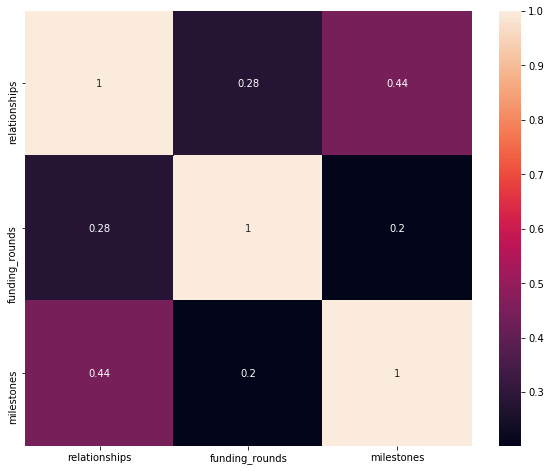

In [27]:
# Корреляция Кендалла
plt.rcParams["figure.figsize"] = (10,8)
Kendall_correlation(df_qualitative)

In [28]:
df_nominative

,state_code,city,category_code
0,CA,San Diego,music
1,CA,Los Gatos,enterprise
2,CA,San Diego,web
3,CA,Cupertino,software
4,CA,San Francisco,games_video
...,...,...,...
918,CA,San Francisco,advertising
919,MA,Burlington,security
920,CA,Sunnyvale,biotech
921,CA,San Francisco,software


Слишком сильно скореллированных признаков тоже нет.Что интересно для этого датасета - все признаки  имеют положительную корреляцию.
Теперь перейдем к количественным признакам.

##### Обработка количественных признаков

Также сперва посмотрим на данные. Количественные признаки, как правило, имеют больший разброс, поэтому осмотрим их на наличие выбросов, используя метод IQR.

In [29]:
find_outliers(df_quantitative)

количество выбросов в столбце age_first_funding_year - 21
количество выбросов в столбце age_last_funding_year - 12
количество выбросов в столбце funding_total_usd - 65
количество выбросов в столбце avg_participants - 28


Нашлось некоторое количество выбросов. Попробуем логарифмировать признаки funding_total_usd и avg_participants.

In [30]:
#df['age_first_funding_year'] = np.log(df['age_first_funding_year']+1)
#df['age_last_funding_year'] = np.log(df['age_last_funding_year']+1)
df['funding_total_usd'] = np.log(df['funding_total_usd']+1)
df['avg_participants'] = np.log(df['avg_participants']+1)

In [31]:
find_outliers(df_quantitative)

количество выбросов в столбце age_first_funding_year - 21
количество выбросов в столбце age_last_funding_year - 12
количество выбросов в столбце funding_total_usd - 0
количество выбросов в столбце avg_participants - 0


После логарифмирования признаков age_first_funding_year и age_last_funding_year появились значения np.nan. Заменим их на среднее.

In [32]:
#df['age_first_funding_year'] = df['age_first_funding_year'].fillna(df['age_first_funding_year'].mean())
#df['age_last_funding_year'] = df['age_last_funding_year'].fillna(df['age_last_funding_year'].mean())

Далее посмотрим на корреляции. Будем использовать два метода - Пирсона и Спирмена. 
Метод Спирмена считается более совершенным, т.к. менее чуствителен к выбросам.

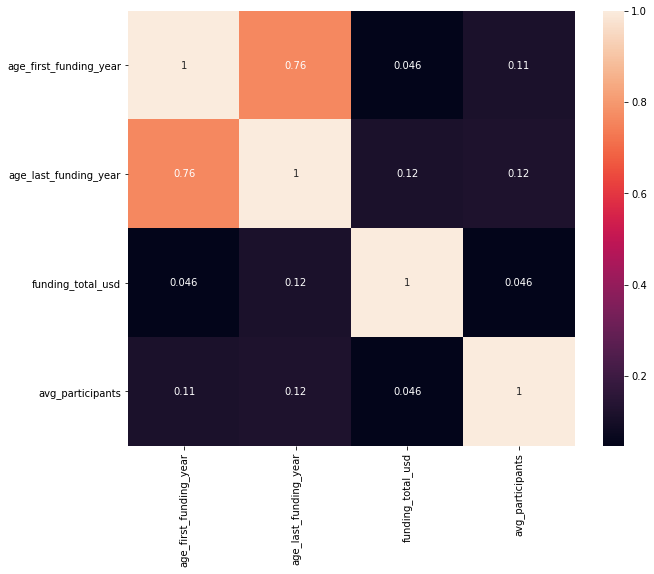

In [33]:
#Корреляция Пирсона
plt.rcParams["figure.figsize"] = (10,8)
pearson_correlation(df_quantitative)

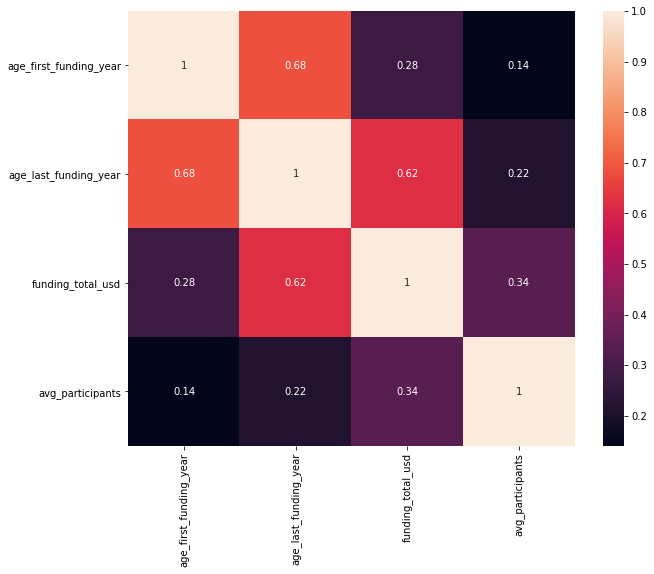

In [34]:
#Корреляция Спирмена
plt.rcParams["figure.figsize"] = (10,8)
spearman_correlation(df_quantitative)

Корреляция Спирмена показывает меньшую степень корреляции количественных признаков между собой, чем корреляция Пирсона. 

##### Обработка номинативных признаков

Теперь можно перейти к номинативным признаками. Проведем проверку распределения признаков в с помощью теста стьюдента.

In [35]:
for col in df:
    if col in nominative:
        student_test(df,col)

E:\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3724: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
E:\anaconda3\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Найдены статистически значимые различия для колонки state_code
Найдены статистически значимые различия для колонки city
Найдены статистически значимые различия для колонки category_code


Все три номинативных признака имеют статистически значимые различия согласно тесту Стдьюдента. Теперь посмотрим матрицу корреляций, используя коэффициент Крамера.

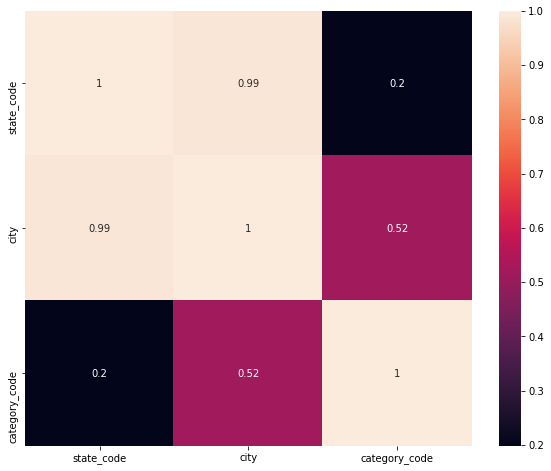

In [36]:
df_nominative = df_nominative.apply(lambda x: x.astype("category") if x.dtype == "O" else x)
cramersv = am.CramersV(df_nominative) 
cramersv_matrix = cramersv.fit()
plt.rcParams["figure.figsize"] = (10,8)
display(sns.heatmap(cramersv_matrix, annot=True))

Обнаружилась почти 100%-я корреляция между городом и штатом. Ответ гже-то на поверхности, но почему-то я до него не дохожу:)

##### Обработка признаков, содержащих время и дату

В первых итерациях я не буду использовать эти признаки для обучения. Посмотрим, какой результат будет без них

In [37]:
##### Обработка признаков, содержащих время и дату

### Подготовка данных к машинному обучению

На этом этапе мы избавимся от ненужных столбцов, выберем признаки для обучения модели и разобьем данные на тестовые и тренировочные. Для начала отбросим в сторону категориальные переменные и посмотрим, какие из оставшихся пригодятся нам для модели.

In [38]:
# отбрасываем лишние признаки
df = df.drop(['longitude', \
'latitude','id','founded_at','first_funding_at','last_funding_at','status','zip_code','name'],axis=1)

In [39]:
# Смотрим на получившийся датасет
df

,state_code,city,labels,age_first_funding_year,age_last_funding_year,relationships,funding_rounds,funding_total_usd,milestones,category_code,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,is_top500
0,CA,San Diego,1,2.2493,3.0027,3,3,12.834684,3,music,0,1,0,0,0,0,0.693147,0
1,CA,Los Gatos,1,5.1260,9.9973,9,4,17.506887,1,enterprise,1,0,0,1,1,1,1.749200,1
2,CA,San Diego,1,1.0329,1.0329,5,1,14.771022,2,web,0,0,1,0,0,0,1.609438,1
3,CA,Cupertino,1,3.1315,5.3151,5,3,17.504390,1,software,0,0,0,1,1,1,1.466329,1
4,CA,San Francisco,0,0.0000,1.6685,2,2,14.077876,1,games_video,1,1,0,0,0,0,0.693147,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
918,CA,San Francisco,1,0.5178,0.5178,9,1,13.910822,2,advertising,0,0,1,0,0,0,1.945910,1
919,MA,Burlington,0,7.2521,9.2274,1,3,17.766754,1,security,1,0,0,1,0,0,1.299292,1
920,CA,Sunnyvale,0,8.4959,8.4959,5,1,17.599700,1,biotech,0,0,0,0,0,1,2.197225,1
921,CA,San Francisco,1,0.7589,2.8329,12,2,16.556351,2,software,0,0,1,1,0,0,0.693147,1


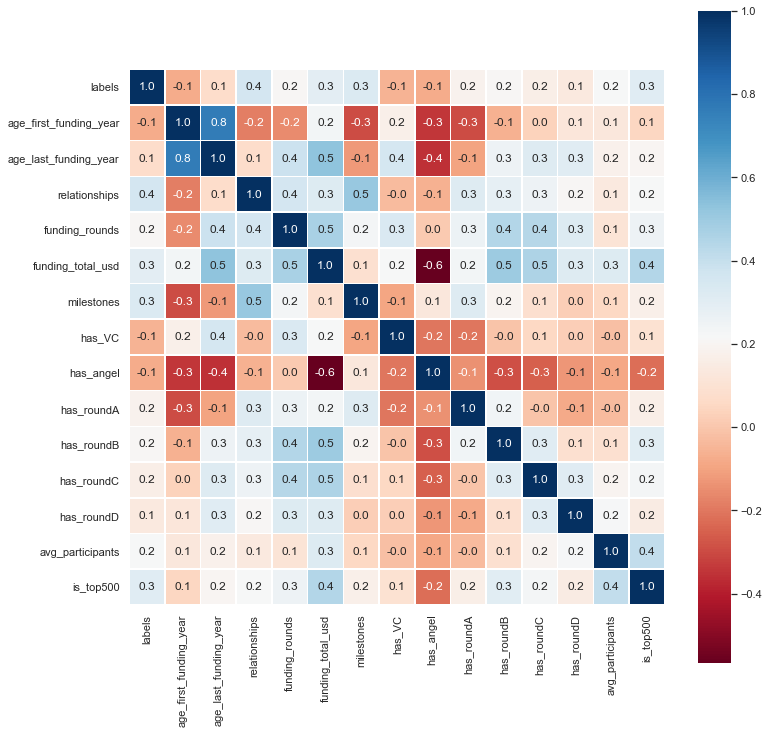

In [40]:
# Построим корреляционную матрицу для всех признаков
sns.set(font_scale=1)
plt.subplots(figsize=(12, 12))
sns.heatmap(df.corr(), square=True,
              annot=True, fmt=".1f", linewidths=0.5, cmap="RdBu")

Посмотрев на корреляционную матрицу всех числовых признаков, можно сравнить их корреляцию с целевой переменной (labels).
В данном случае корреляционная матрица выглядит довольно хорошо, можно оставить все признаки.

In [41]:
#df = df.drop(['is_software','is_web','is_mobile','is_advertising', \
#'is_gamesvideo','is_biotech','is_othercategory','name'],axis=1)

Преобразуем категориальные признаки в dummy-переменные.

In [42]:
df = pd.get_dummies(df,columns=['state_code','city','category_code'])
df = df.fillna(0)

In [43]:
# Задаем целевую переменную и набор переменных для обучения
y = df['labels']
x = df.drop('labels',axis=1)

In [44]:
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.3,random_state=31)

### Машинное обучение

Пришло время строить модели. Попробуем несколько моделей машинного обучения - LogisticRegression, SGDClassifier

#### LogisticRegression

In [45]:
model_log = LogisticRegression(solver='saga',
                           max_iter=800,
                           penalty="elasticnet",
                           l1_ratio=0.1,
)
model_log.fit(x_train, y_train)

E:\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(l1_ratio=0.1, max_iter=800, penalty='elasticnet',
                   solver='saga')

In [46]:
y_pred_proba_log = model_log.predict_proba(x_valid)[:,1]
y_pred_log = model_log.predict(x_valid)
print(accuracy_score(y_valid,y_pred_log))
print(f1_score(y_valid,y_pred_log))

0.7436823104693141
0.8136482939632546


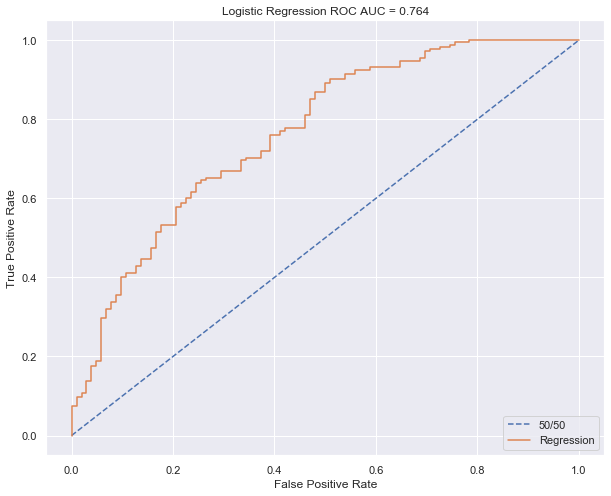

In [47]:
#Кривая ROC-AUC
fpr, tpr, threshold = roc_curve(y_valid,y_pred_proba_log)
roc_auc = roc_auc_score(y_valid,y_pred_proba_log)

plt.figure()
plt.plot([0, 1], label='50/50', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

#### SGDClassifier

In [48]:
model_sgd = SGDClassifier(loss='log',
                         max_iter=600,
                         penalty="l2",
                         l1_ratio=0.2,
)
model_sgd.fit(x_train, y_train)

SGDClassifier(l1_ratio=0.2, loss='log', max_iter=600)

In [49]:
y_pred_proba_sgd = model_sgd.predict_proba(x_valid)[:,1]
y_pred_sgd= model_sgd.predict(x_valid)
print(accuracy_score(y_valid,y_pred_sgd))
print(f1_score(y_valid,y_pred_sgd))

0.7256317689530686
0.812807881773399


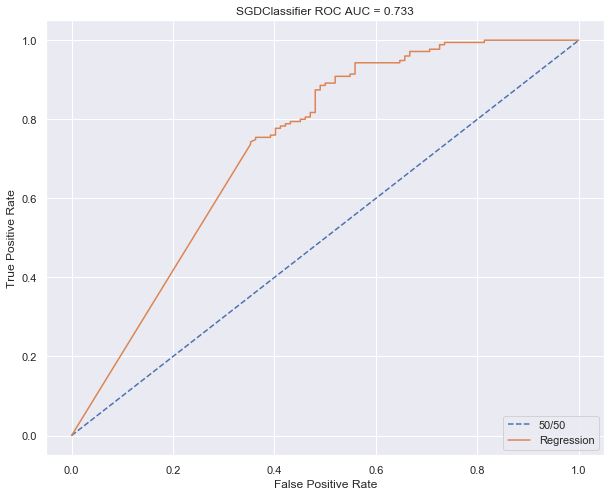

In [50]:
#Кривая ROC-AUC
fpr, tpr, threshold = roc_curve(y_valid,y_pred_proba_sgd)
roc_auc = roc_auc_score(y_valid,y_pred_proba_sgd)

plt.figure()
plt.plot([0, 1], label='50/50', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('SGDClassifier ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

#### RandomForestClassifier

In [51]:
model_rfc = RandomForestClassifier(n_estimators=1000)
model_rfc.fit(x_train, y_train)

RandomForestClassifier(n_estimators=1000)

In [52]:
y_pred_proba_rfc = model_rfc.predict_proba(x_valid)[:,1]
y_pred_rfc= model_rfc.predict(x_valid)
print(accuracy_score(y_valid,y_pred_rfc))
print(f1_score(y_valid,y_pred_rfc))

0.7833935018050542
0.8445595854922279


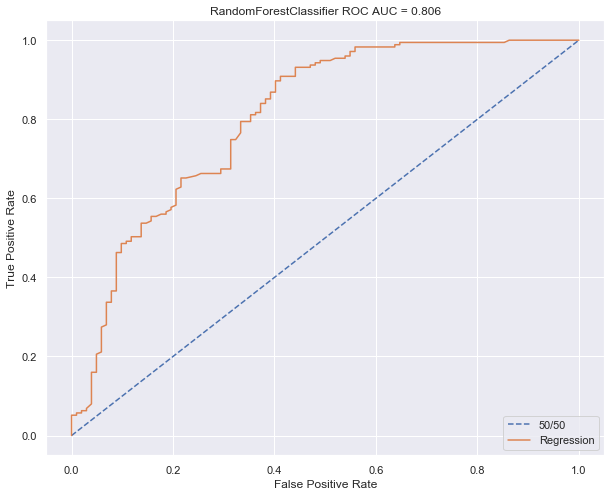

In [53]:
#Кривая ROC-AUC
fpr, tpr, threshold = roc_curve(y_valid,y_pred_proba_rfc)
roc_auc = roc_auc_score(y_valid,y_pred_proba_rfc)

plt.figure()
plt.plot([0, 1], label='50/50', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('RandomForestClassifier ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

#### Подбор параметров с помощью GridSearch

In [54]:
model_log = LogisticRegression()
model_rfc = RandomForestClassifier()
model_sgd = SGDClassifier()

models = [model_log,model_rfc,model_sgd]

for model in models:
  if model == model_log:
    param_grid = [
    {'penalty': ['l1','l2'], 
     'solver': ['liblinear', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'max_iter':[600,700,800,900,1000]},
    ]
  elif model == model_rfc:
    param_grid = [
    {'n_estimators': [600,700,800,900,1000,1100,1200], 
     'max_depth': [1,2,3,4,5,6]},  
    ]
  elif model == model_sgd:
    param_grid = [
    {'penalty': ['l1','l2'], 
#     'learning_rate': [0.1,0.2,0.3,0.4,0.5,0.6],
     'loss' : ['log'],
     'class_weight':['none', 'balanced']},
    ]
  gridsearch = GridSearchCV(model, param_grid, scoring='roc_auc', n_jobs=-1)
  gridsearch.fit(x_train, y_train)
  model = gridsearch.best_estimator_
  print('')
  print(model)
  print('')
  y_pred_proba = model.predict_proba(x_valid)[:,1]
  y_pred = model.predict(x_valid)
  print(accuracy_score(y_valid,y_pred))
  print(f1_score(y_valid,y_pred))

E:\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:921: UserWarning: One or more of the test scores are non-finite: [       nan 0.79857398        nan 0.80005998        nan 0.7988357
        nan 0.79995699        nan 0.79894095        nan 0.79942733
        nan 0.79925784        nan 0.79895057        nan 0.79915372
        nan 0.79841807 0.7980262  0.79665507 0.79077526 0.79565091
 0.79797329 0.79612257 0.79077526 0.79548935 0.79797329 0.79665054
 0.79077526 0.79511615 0.79797329 0.79648615 0.79077526 0.79543417
 0.79807911 0.79606287 0.79077526 0.79559234]
  category=UserWarning
E:\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



LogisticRegression(class_weight='none', max_iter=600, solver='saga')

0.7328519855595668
0.8052631578947369

RandomForestClassifier(max_depth=6, n_estimators=700)

0.7581227436823105
0.837772397094431

SGDClassifier(class_weight='balanced', loss='log')

0.48014440433212996
0.3333333333333333


E:\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:921: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.77268653 0.78426478]
  category=UserWarning
